This notebook shows pre-processing part of OCR recognition

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import argparse
from PIL import Image
from PIL import ImageFilter
from pylab import *

First step is to insert image

In [5]:
img = Image.open('./textArea01.png')

In [6]:
kernel1 = np.array([[-1,-1,-1],[2, 2, 2],[-1, -1, -1]])
kernel2 = np.array([[-1, 2,-1],[-1, 2, -1],[-1, 2, -1]])
kernel3 = np.array([[2,-1,-1],[-1, 2, -1],[-1, -1, 2]])
kernel4 = np.array([[-1,-1,2],[-1, 2, -1],[2, -1, -1]])

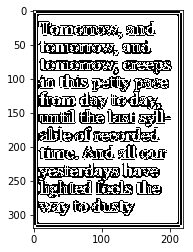

In [7]:
#http://stackoverflow.com/questions/34981144/split-text-lines-in-scanned-document
img = np.asarray(img)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
plt.imshow(th3,'gray')
plt.show()

In [8]:
#http://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
image = cv2.imread("./skew2.png")
#image = cv2.imread("C:\Users\Franjo\Documents\FER\DOAS\DOAS - Projekt\cover.png")

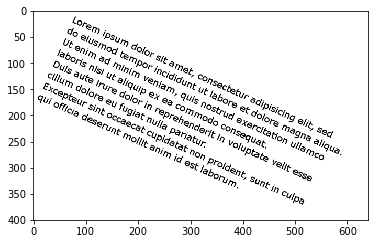

In [9]:
plt.imshow(image,"gray")
plt.show()

DENOISINT IMAGE

http://docs.opencv.org/3.0-beta/modules/photo/doc/denoising.html


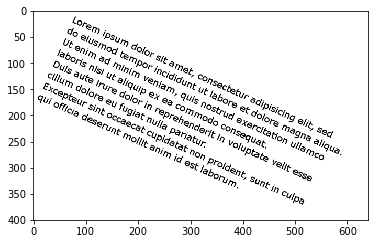

In [10]:
#Funkcija kao ulaz uzima grayscale sliku a kao izlaz daje grayscale slike
def denoise(image):
    #Parametri funkcije su ulazna slike, h=3 - regulira snagu filtra, velicina prozora,
    # te velicina search prozora - Size in pixels of the window that is used to compute weighted average for given pixel. 
    #Should be odd. Affect performance linearly: greater searchWindowsSize - greater denoising time. 
    #Recommended value 21 pixels
    output=cv2.fastNlMeansDenoising(image,3,7,21)
    return output
denoised = denoise(image)
plt.imshow(denoised,'gray')
plt.show()

BINARISATION

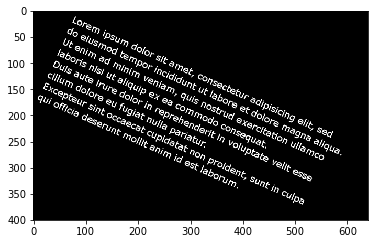

In [11]:
def binarize(img):
    # convert the image to grayscale and flip the foreground
    # and background to ensure foreground is now "white" and
    # the background is "black"
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    #http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
    ##KORISTI SE LOKALNO IZJEDNACANJE HISTOGRAMA
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)

    # threshold the image, setting all foreground pixels to
    # 255 and all background pixels to 0
    thresh = cv2.threshold(cl1, 0, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return gray,thresh
gray,thresh = binarize(image)
plt.imshow(gray,'gray')
plt.show()

CALCULATING ANGLE

In [12]:
def calculateAngle(thresh):
    # grab the (x, y) coordinates of all pixel values that
    # are greater than zero, then use these coordinates to
    # compute a rotated bounding box that contains all
    # coordinates
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]

    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)

    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
        angle = -angle
    return angle
angle = calculateAngle(thresh)

ROTATING IMAGE

In [13]:
# rotate the image to deskew it
def rotateImage(image,angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def rotate(image):
    gray,thresh = binarize(image)
    angle = calculateAngle(thresh)
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

rotated = rotateImage(image,angle)
rotated2 = rotate(image)

In [14]:
# draw the correction angle on the image so we can validate it
cv2.putText(rotated2, "Angle: {:.2f} degrees".format(angle),(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
 
# show the output image
print("[INFO] angle: {:.3f}".format(angle))
cv2.imshow("Input", image)
cv2.imshow("Rotated", rotated2)
cv2.waitKey(0)

[INFO] angle: 23.562


-1

In [15]:
# draw the correction angle on the image so we can validate it
cv2.putText(rotated, "Angle: {:.2f} degrees".format(angle),(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
 
# show the output image
print("[INFO] angle: {:.3f}".format(angle))
cv2.imshow("Input", image)
cv2.imshow("Rotated", rotated)
cv2.waitKey(0)

[INFO] angle: 23.562


-1

#http://stackoverflow.com/questions/4632174/what-processing-steps-should-i-use-to-clean-photos-of-line-drawings
#grey = im.convert('L')
#im = Image.open(r'c:\temp\temp.png')
#image=Image.fromarray(image)
"""
white = image.filter(ImageFilter.BLUR).filter(ImageFilter.MaxFilter(15))
print gray.shape
width,height = gray.shape
impix = image
whitepix = white
greypix = grey.load()
for y in range(height):
    for x in range(width):
        greypix[x,y] = min(255, max(255 * impix[x,y][0] / whitepix[x,y][0], 255 * impix[x,y][2] / whitepix[x,y][3], 255 * impix[x,y][4] / whitepix[x,y][5]))
        """

LINE REMOVAL

In [16]:
def lineRemoval(image):
    img=image
    laplacian = cv2.Laplacian(img,cv2.CV_8UC1) # Laplacian OR
    edges = cv2.Canny(img,80,10,apertureSize = 3) # canny Edge OR
    # Output dtype = cv2.CV_8U # Sobel
    sobelx8u = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=5)
    # Output dtype = cv2.CV_64F. Then take its absolute and convert to cv2.CV_8U
    sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    abs_sobel64f = np.absolute(sobelx64f)
    sobel_8u = np.uint8(abs_sobel64f)

    # Hough's Probabilistic Line Transform 
    minLineLength = 900
    maxLineGap = 100
    lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
    if lines != None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img,(x1,y1),(x2,y2),(255,255,255),2)
    return img
img = lineRemoval(rotated)
cv2.imshow("Input", img)
cv2.waitKey(0)

-1

In [17]:
#Funkcija uzima kao ulaz sliku
def connectedComponents(image):
    #binariziraj sliku
    gray,thresh = binarize(image)
    #Ova funkcija kao ulaz uzima binarnu sliku te parametar da li gleda 4 ili 8 susjedstvo te vrstu izlazne slike
    connectivity=4
    output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
    return output

out = connectedComponents(image)
print image[0]

AttributeError: 'module' object has no attribute 'connectedComponentsWithStats'

In [18]:
#Funkcija za racunanje centra konture
def getCenters(contour):
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return cx,cy

# This is a contour detection for object detection 

https://stackoverflow.com/questions/34389384/improve-contour-detection-with-opencv-python

In [19]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import math
from pylab import array, plot, show, axis, arange, figure, uint8 

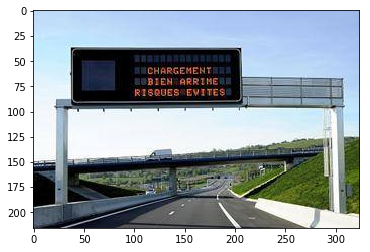

In [20]:
#img = cv2.imread('./imposed.png')
#img = cv2.imread('./sceneembeddedtext.png')
img = cv2.imread('./image.png')
#img = cv2.resize(img, (0,0), fx=3, fy=3) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [34]:
def getTextCandidates(image):
    #binarize image
    gray, thresh = binarize(denoise(img))
    #get contours od the binary image
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_TC89_KCOS)
    #sort contours by size - largest to smallest
    contours = sorted(contours, key=cv2.contourArea,reverse=True)
    #Calculate bounding boxes for contours
    bounding_boxes = []
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        bounding_boxes.append([x, y, w, h])
    #Return bounding boxes as a list of candidates
    return bounding_boxes

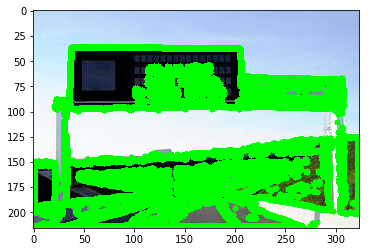

In [26]:
#Prepocess
#Binarizacija slike
gray, thresh = binarize(denoise(img))
#Dilatacija slike
#kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
#dilated = cv2.dilate(thresh, kernel, iterations=9)
# Find contours
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_TC89_KCOS)
#print len(cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE))
contours = sorted(contours, key=cv2.contourArea,reverse=True)

# Select long perimeters only
perimeters = [cv2.arcLength(contours[i],True) for i in range(len(contours))]
#print len(perimeters)
#print perimeters[50]

#listindex=[i for i in range(len(perimeters)) if perimeters[i]>perimeters[0]/2]
listindex=[i for i in range(len(perimeters))]

# Show image
imgcont = img.copy()
[cv2.drawContours(imgcont, [contours[i]], 0, (0,255,0), 5) for i in listindex]
plt.imshow(imgcont)
plt.show()

543


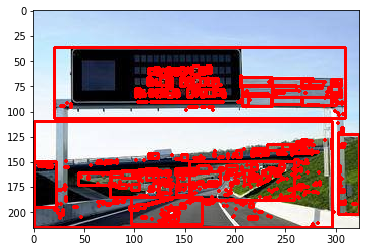

In [39]:
imgcont2=img.copy()
bounding_boxes = []
candidates = []
#Kandidati za klasifikaciju
for c in contours:
    (x, y, w, h) = cv2.boundingRect(c)
    bounding_boxes.append([x, y, w, h])
    cv2.rectangle(imgcont2,(x,y),(x+w,y+h),(255,0,0),2)
    candidates.append(np.resize(imgcont2[x:x+w,y:y+h], (30,30)))
print len(candidates) 

for candidate in candidates:
    if i==0:
        samples = resize(roi, (20,20))
        coordinates.append(region.bbox)
        i+=1
    elif i==1:
        roismall = resize(roi, (20,20))
        samples = np.concatenate((samples[None,:,:], roismall[None,:,:]), axis=0)
        coordinates.append(region.bbox)
        i+=1
    else:
        roismall = resize(roi, (20,20))
        samples = np.concatenate((samples[:,:,:], roismall[None,:,:]), axis=0)
coordinates.append(region.bbox)
plt.imshow(imgcont2)
plt.show()

#https://stackoverflow.com/questions/19363293/whats-the-fastest-way-to-increase-color-image-contrast-with-opencv-in-python-c
# Image data
image = cv2.imread('imgur.png',0) # load as 1-channel 8bit grayscale
cv2.imshow('image',image)
maxIntensity = 255.0 # depends on dtype of image data
x = arange(maxIntensity) 

# Parameters for manipulating image data
phi = 1
theta = 1

# Increase intensity such that
# dark pixels become much brighter, 
# bright pixels become slightly bright
newImage0 = (maxIntensity/phi)*(image/(maxIntensity/theta))**0.5
newImage0 = array(newImage0,dtype=uint8)

cv2.imshow('newImage0',newImage0)
cv2.imwrite('newImage0.jpg',newImage0)

In [28]:
cv_size = lambda img: tuple(img.shape[1::-1])

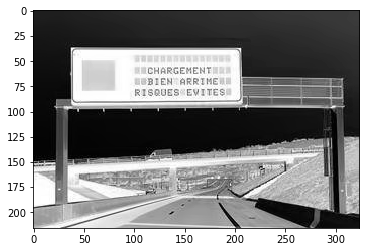

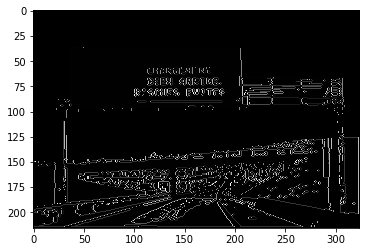

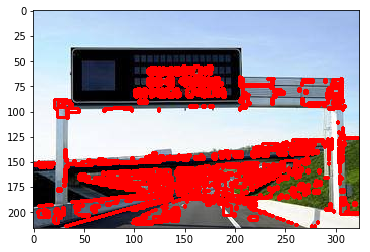

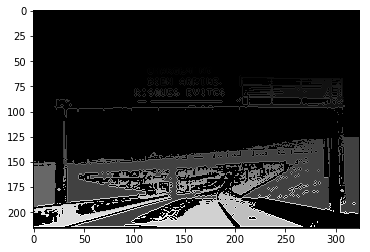

In [37]:
img2=gray.copy()
imgcont4=img.copy()
#img2=img2.astype(np.uint8)
#img2=cv2.equalizeHist(img2)
# create a CLAHE object (Arguments are optional).
#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#cl1 = clahe.apply(gray)
#ides,idem = binarize(cl1)

#hist1=cv2.calcHist(img2)
#hist2=cv2.calcHist(gray)
#print cv2.compareHist(hist2,hist1)
plt.imshow(img2,'gray')
plt.show()
plt.imshow(thresh,'gray')
plt.show()
coordinates = []
size = cv_size(img)
#Labeling image
label_image = measure.label(thresh,8)
#Create bounding box arounf every candidate - not working ?!?!?!?
for region in regionprops(label_image):
    #print region.filled_area
    if region.filled_area > 1 and region.filled_area <20:
        minr, minc, maxr, maxc = region.bbox
        margin = 3
        minr, minc, maxr, maxc = minr-margin, minc-margin, maxr+margin, maxc+margin
        coordinates.append(region.bbox)

for coord in coordinates:
    (y, x, h, w) = coord
    cv2.rectangle(imgcont4,(x,y),(w,h),(255,0,0),2)
plt.imshow(imgcont4)
plt.show()
plt.imshow(label_image,'gray')
plt.show()

# OVO JE OD OVOG FRAJERA
https://github.com/FraPochetti/ImageTextRecognition

In [30]:
import numpy as np
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.transform import resize
import cPickle
from matplotlib import pyplot as plt
from skimage.morphology import closing, square
from skimage.measure import regionprops
from skimage import restoration
from skimage import measure
from skimage.color import label2rgb
import matplotlib.patches as mpatches

0.428545239757


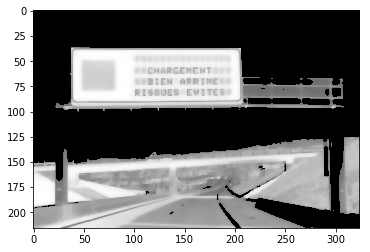

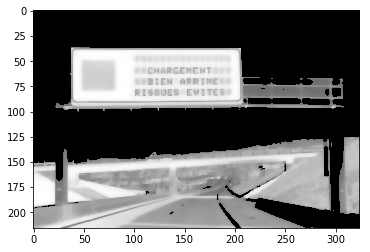

In [32]:
image2 = restoration.denoise_tv_chambolle(gray, weight=0.1)
thresh2 = threshold_otsu(image2)
print thresh2
image2 = np.array(image2)
#image2[image2>thresh2]=255
image2[image2<=thresh2]=0
#print thresh2*255
plt.imshow(image2,"gray")
plt.show()
#bw = closing(image2 > thresh2, square(2))
image2 = cv2.normalize(image2, image2, alpha=100, beta=200, norm_type=cv2.NORM_MINMAX)
plt.imshow(image2,"gray")
plt.show()

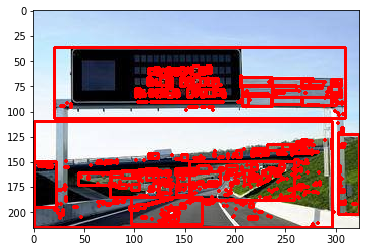

In [35]:
imgcont3 = img.copy()
ides=getTextCandidates(image2)
for c in ides:
    (x, y, w, h) = c
    cv2.rectangle(imgcont3,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(imgcont3)
plt.show()

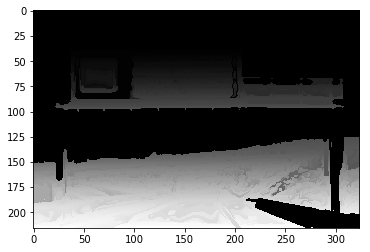

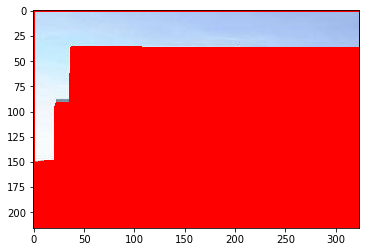

In [36]:
imgcont4 = img.copy()
label_image = measure.label(image2)   
borders = np.logical_xor(image2, image2)
label_image[borders] = -1
plt.imshow(label_image,"gray")
plt.show()

coordinates = []
i=0

for region in regionprops(label_image):
    if region.area > 10:
        minr, minc, maxr, maxc = region.bbox
        margin = 3
        minr, minc, maxr, maxc = minr-margin, minc-margin, maxr+margin, maxc+margin
    coordinates.append(region.bbox)

for coord in coordinates:
    (y, x, h, w) = coord
    cv2.rectangle(imgcont4,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(imgcont4)
plt.show()
#"""